In [1]:
%matplotlib inline
import sys 
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import random
import pickle
from pathlib import Path
from itertools import product

modpath = "../scripts"
sys.path.append(os.path.abspath(modpath))

from misc import pickler, open_table
import plot_utils

/storage/homefs/pd21v747/.local/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.0' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/storage/homefs/pd21v747/.local/lib/python3.9/site-packages/pandas/core/arrays/masked.py:62: UserWarning: Pandas requires version '1.3.4' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


In [2]:
DEAs = ["edgerlrt", "edger", "deseq2"]
outlier_methods = ["none","jk","pcah"]
all_N = [3,4,5,6,7,8,9,10,12,15]

# pretty names
prdea = {"edgerlrt":"edgeR LRT","edger":"edgeR QLF","deseq2":"DESeq2 Wald"}
prout = {"none":"None","jk":"Jackknife","pcah":"rPCA"}

In [3]:
from misc import Timer
with Timer(name="context manager"):
    pass

Elapsed time: 0.0000 seconds


# Effect size inflation vs FDR 

Reviewer 1 comment: 

"It seems counterintuitive that, in small cohorts, the effect estimates are inflated (Fig. 5), but this doesn’t inflate the false positive rate (Fig. 2). Can you explain this? Is it that the effects are high variance but still unbiased? Perhaps you can find a way to simultaneously visualize effect sizes and whether they eventually lead to false positives."

In [4]:
from misc import open_table, get_grid_size
from process import gene_rep

datapath = "/storage/homefs/pd21v747/datanew"

def gene_reps_all_N(all_N,site,data,out,dea,FDR,logFC,param_set):
    gene_reps = {N: None for N in all_N}
    for N in all_N:
        tab = open_table(f"{datapath}/{site}/{data}/{data}_N{N}/all.FDR.{out}.{dea}.{param_set}")
        tablfc = open_table(f"{datapath}/{site}/{data}/{data}_N{N}/all.logFC.{out}.{dea}.{param_set}")
        gene_reps[N] = gene_rep(tab, logFC_tab=tablfc, FDR=FDR, logFC=logFC, normalize=True)
    return gene_reps


def get_truth_logFC(param_set, n_cohorts):
    
    logFC_test = 0 if param_set == "p1" else 1
    
    truth_logFC = {data: {dea: {N: {"RMSE":[], "logFC":[], "Error": []} for N in all_N_sub} | {"small_N_deg_logFC":[],"small_N_deg_logFC_truth":[]} for dea in DEAs} for data in datasets if "syn_hom" not in data}

    for data in truth_logFC:
        
        print(data)
        
        for dea in ["deseq2", "edgerlrt"]:
            
            path = datasets[data]['datapath'].split(f'/{data}.csv')[0]
            f = f"{path}/{data}.{dea}.lfc{logFC_test}.csv"
            truth_df=pd.read_csv(f, index_col=0, usecols=["Unnamed: 0","logFC"])
            logFC_truth = truth_df["logFC"]
            truth_logFC[data][dea]["truth"] = logFC_truth
            small_N_deg = []
            
            for N in all_N_sub:
                
                path_N = f"{path}/{data}_N{N}"
                cohorts = sorted([f.path for f in os.scandir(path_N) if f.is_dir()])

                for cohort in cohorts[:n_cohorts]:
                    
                    f = f"{cohort}/tab.{out}.{dea}.{param_set}"
                    tab_cohort = open_table(f)

                    logFC_cohort = tab_cohort["logFC"]
                    
                    if cohort == cohorts[0]: 
                        common = logFC_cohort.index.intersection(logFC_truth.index)
                    tab_cohort = tab_cohort.loc[common]

                    if N == all_N_sub[0]:
                        DEG = tab_cohort[(tab_cohort["FDR"]<FDR) & (tab_cohort["logFC"].abs()>logFC)]
                        truth_logFC[data][dea]["small_N_deg_logFC"] += DEG["logFC"].values.tolist()
                        small_N_deg = DEG.index

                    logFC_cohort = tab_cohort["logFC"]
                    rmse = np.sqrt(np.mean((logFC_truth.loc[common].values.flatten()-logFC_cohort.values)**2))
                    truth_logFC[data][dea][N]["RMSE"].append(rmse)
                    truth_logFC[data][dea][N]["Error"] += (logFC_truth.loc[common].values.flatten()-logFC_cohort.values).tolist()
                    truth_logFC[data][dea][N]["logFC"] += logFC_cohort.tolist()

            truth_logFC[data][dea]["small_N_deg_logFC_truth"] += logFC_truth.loc[small_N_deg].values.tolist()
            
    return truth_logFC

# don't forget: deseq2 does not show logCPM but counts

In [5]:
datasetsfile = "/storage/homefs/pd21v747/datanew/multi/datasets.txt"
with open(datasetsfile, "rb") as f:
    datasets = pickle.load(f)

In [6]:
data = "BRCA"
dea = "deseq2"
out = "none"
N = 3

# not FC estimate is not affected by this
paramset = "p1" # no FC cutoff
#paramset = "p2" # formal

site = datasets[data]["site"]
p = f"/storage/homefs/pd21v747/datanew/{site}/{data}/{data}_N{N}/all.logFC.{out}.{dea}.{paramset}"
tab = open_table(p)

p = f"/storage/homefs/pd21v747/datanew/{site}/{data}/{data}_N{N}/all.FDR.{out}.{dea}.{paramset}"
tab_fdr = open_table(p)

mean_lfc = tab.median(axis=1).sort_values(ascending=False)
x = range(len(mean_lfc))

print(len(tab))
tab.head()

18758


,1,2,3,4,5,6,7,8,9,10,...,91,92,93,94,95,96,97,98,99,100
Row,,,,,,,,,,,,,,,,,,,,,
ENSG00000000003,-1.236981,-1.065117,-0.318140,-1.186168,-0.676663,-1.488532,-0.687032,-0.358138,-0.958077,-0.320728,...,-1.451673,-1.564017,-1.386630,-0.167985,-0.524379,-0.581197,0.015136,-0.157270,-0.341198,-2.133774
ENSG00000000005,-3.528613,-4.902033,-3.827559,-3.964970,-4.767310,-2.915722,-1.872100,-2.369576,-3.767920,-4.767497,...,-2.691366,-5.365635,-4.805764,-5.610838,-6.116199,-2.200954,-2.804036,-4.849663,-2.986883,-5.661870
ENSG00000000419,0.577069,0.723840,0.588718,0.255762,0.330952,0.244730,0.200505,0.526518,0.980073,0.204495,...,0.975265,0.499734,0.517676,0.012265,0.669335,0.644969,0.236851,0.016368,0.885193,0.458471
ENSG00000000457,0.220223,0.120000,0.840541,0.327299,0.249410,0.382624,0.298660,0.717217,0.326496,0.769161,...,0.715313,0.103679,0.300795,0.849556,0.994531,0.290377,1.160360,1.593258,0.970101,1.198252
ENSG00000000460,0.600733,1.134824,1.695607,0.892396,1.021273,1.016350,0.758681,1.711125,1.321755,0.931396,...,1.298043,0.943413,0.756048,1.414260,1.703092,1.047787,1.700460,1.421378,2.196038,1.999289


In [7]:
# not really a confidence interval
CI = 0.5
up_lim = (1+CI)/2
low_lim = (1-CI)/2
cutoff = 1

#std_lfc = tab.std(axis=1).loc[mean_lfc.index]
up = tab.quantile(up_lim,axis=1).loc[mean_lfc.index]
low = tab.quantile(low_lim,axis=1).loc[mean_lfc.index]

crossing = mean_lfc[ ((up>-cutoff) & (low<-cutoff)) | ((up>cutoff) & (low<cutoff)) ]
cross_ind = np.array(x)[mean_lfc.index.isin(crossing.index)]

mean_pass_cutoff = mean_lfc[mean_lfc.abs()>cutoff]

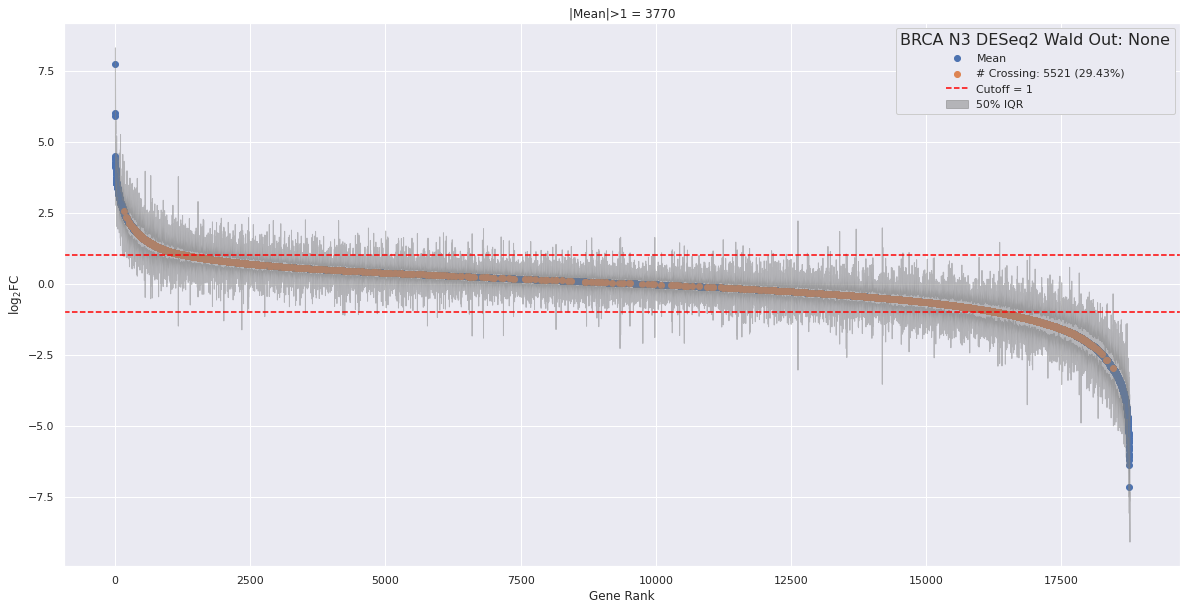

In [8]:
fig, ax = plt.subplots(1,1,figsize=(20,10))
#ax.plot(x, mean_lfc,lw=4,label="Mean")
ax.scatter(x, mean_lfc,label="Mean")
ax.scatter(cross_ind, crossing, label=f"# Crossing: {len(crossing)} ({len(crossing)/len(x):.2%})")
ax.axhline(cutoff,ls="--",c="red",label=f"Cutoff = {cutoff}")
ax.axhline(-cutoff,ls="--",c="red")
ax.fill_between(x, up, low, edgecolor="none",color="grey",alpha=0.5,label=f"{CI:.0%} IQR")
#ax.fill_between(cross_ind, up.iloc[cross_ind], low.iloc[cross_ind], edgecolor="none",color="pink",alpha=0.5,label="Crossing")
ax.set_xlabel("Gene Rank")
ax.set_ylabel(r"log$_2$FC")
ax.set_title(f"|Mean|>{cutoff} = {len(mean_pass_cutoff)}")
ax.legend(framealpha=1,title=f"{data} N{N} {prdea[dea]} Out: {prout[out]}",title_fontsize=16)
#ax.set_xlim(8360,8400)

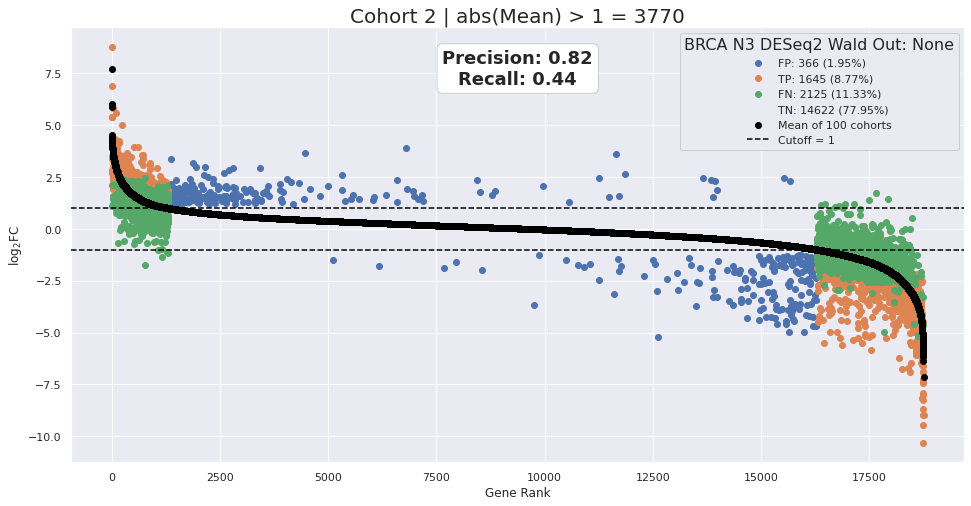

In [81]:
fig, ax = plt.subplots(1,1,figsize=(16,8))

fdr_thresh = 0.05
cohort = 2

## Post hoc thresholding
tab_cohort =  tab.iloc[:,cohort-1].loc[mean_lfc.index]
tab_cohort_fdr =  tab_fdr.iloc[:,cohort-1].loc[mean_lfc.index]

if (tab_cohort_fdr.isna().sum()):
    tab_cohort_fdr = tab_cohort_fdr.fillna(1)
    
mask = (tab_cohort.abs() >= 1) & (mean_lfc.abs()<1) & (tab_cohort_fdr<fdr_thresh)
tab_cohort_FP = tab_cohort[mask]
x_FP = np.array(x)[mask]

mask = (tab_cohort.abs() >= 1) & (mean_lfc.abs()>=1) & (tab_cohort_fdr<fdr_thresh)
tab_cohort_TP = tab_cohort[mask]
x_TP = np.array(x)[mask]

mask = (mean_lfc.abs()>=1) & (tab_cohort_fdr>=fdr_thresh)
tab_cohort_FN = tab_cohort[mask]
x_FN = np.array(x)[mask]

mask = (mean_lfc.abs()<1) & (tab_cohort_fdr>=fdr_thresh)
tab_cohort_TN = tab_cohort[mask]
x_TN = np.array(x)[mask]

assert len(x_TP) + len(x_FP) + len(x_FN) + len(x_TN) == len(x)

#ax.plot(x, mean_lfc,lw=4,label="Mean")
ax.scatter(x_FP, tab_cohort_FP,label=f"FP: {len(x_FP)} ({len(x_FP)/len(x):.2%})", zorder=2)
ax.scatter(x_TP, tab_cohort_TP,label=f"TP: {len(x_TP)} ({len(x_TP)/len(x):.2%})", zorder=2)
ax.scatter(x_FN, tab_cohort_FN,label=f"FN: {len(x_FN)} ({len(x_FN)/len(x):.2%})", zorder=2)
ax.scatter(x_TN, tab_cohort_TN,label=f"TN: {len(x_TN)} ({len(x_TN)/len(x):.2%})", zorder=2, alpha=0)
ax.scatter(x, mean_lfc,label="Mean of 100 cohorts", zorder=3, color="black")

#ax.scatter(cross_ind, crossing, label=f"# Crossing: {len(crossing)} ({len(crossing)/len(x):.2%})")
ax.axhline(cutoff,ls="--",c="black",label=f"Cutoff = {cutoff}", zorder=9)
ax.axhline(-cutoff,ls="--",c="black", zorder=9)

bbox=dict(boxstyle="round", fc="1",ec="0.8")
prec = len(x_TP) / (len(x_TP) + len(x_FP))
rec = len(x_TP) / (len(x_TP) + len(x_FN))
metrics = f"Precision: {prec:.2f}\nRecall: {rec:.2f}"
ax.text(0.5, 0.95, metrics, ha='center', va='top', transform=ax.transAxes, bbox=bbox, fontsize=18, weight="bold")

ax.set_xlabel("Gene Rank")
ax.set_ylabel(r"log$_2$FC")
ax.set_title(f"Cohort {cohort} | abs(Mean) > {cutoff} = {len(mean_pass_cutoff)}", fontsize=20)
ax.legend(framealpha=1,title=f"{data} N{N} {prdea[dea]} Out: {prout[out]}",title_fontsize=16)
#ax.set_xlim(8360,8400)

<Axes: >

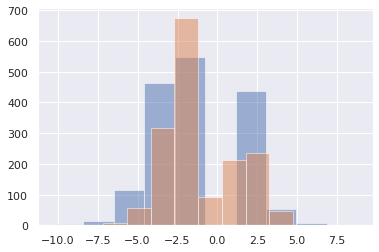

In [78]:
tab_cohort_TP.hist(bins=10,alpha=0.5)
mean_lfc.loc[tab_cohort_TP.index].hist(bins=10,alpha=0.5)

In [58]:
site = datasets[data]["site"]
p = f"/storage/homefs/pd21v747/datanew/{site}/{data}/{data}.{dea}.lfc{0}"
tab_gt = open_table(p)
print(len(tab_gt))
tab_gt.head()

18952


,logFC,logCPM,F,PValue,FDR
ENSG00000101236,1.290976,5.430524,331.317235,3.511398e-26,6.654801e-22
ENSG00000117298,1.536679,8.607239,294.608667,6.891674e-25,5.939689e-21
ENSG00000169762,-0.748758,5.227413,289.087192,1.107461e-24,5.939689e-21
ENSG00000159842,1.495539,6.266628,287.658391,1.253628e-24,5.939689e-21
ENSG00000141858,1.323267,5.058325,284.268325,1.685803e-24,6.389868e-21


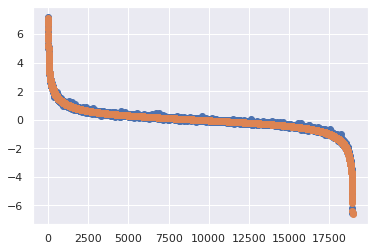

In [76]:
a=tab_gt.loc[mean_lfc.index.intersection(tab_gt.index)]["logFC"]
# (a-mean_lfc).hist(bins=100)
# (a-mean_lfc).mean()

plt.scatter(range(len(a)), a,label="Mean of 100 cohorts", zorder=3)
plt.scatter(x, mean_lfc,label="Mean of 100 cohorts", zorder=4)

## Heteroskedasticity

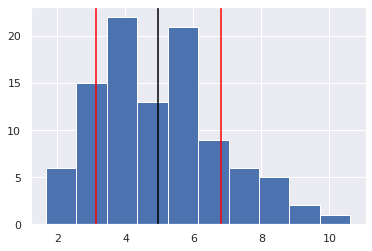

In [37]:
i = 1
m = tab.abs().iloc[i].mean()
s = tab.abs().iloc[i].std()
tab.abs().iloc[i].hist()
plt.axvline(m, color="black")
plt.axvline(m-s, color="red")
plt.axvline(m+s, color="red")

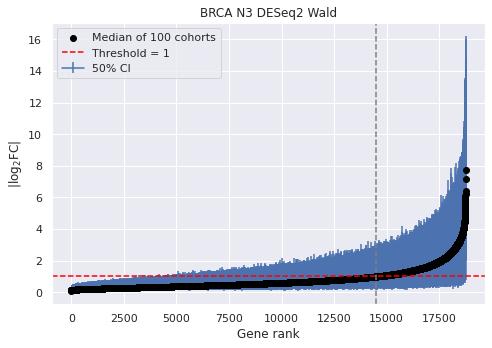

In [57]:
CI = 0.5
up_lim = (1+CI)/2
low_lim = (1-CI)/2

cutoff = 1

mean_lfc = tab.abs().median(axis=1).sort_values(ascending=True)

up = tab.abs().quantile(up_lim,axis=1).loc[mean_lfc.index]
low = tab.abs().quantile(low_lim,axis=1).loc[mean_lfc.index]
spread = np.array([low.values, up.values])

# spread = tab.abs().std(axis=1).loc[mean_lfc.index]

cutoff = 1

fig, ax= plt.subplots(1,1,figsize=(7,5))
ax.errorbar(range(len(mean_lfc)), mean_lfc, yerr=spread,zorder=1, label=f"{CI:.0%} CI")
ax.scatter(range(len(mean_lfc)), mean_lfc,color="black",zorder=2, label="Median of 100 cohorts")
ax.set(ylabel=r"|log$_2$FC|",xlabel="Gene rank", title=f"{data} N{N} {prdea[dea]}")
ax.axhline(cutoff,ls="--",color="red",label=f"Threshold = {cutoff}")
ax.axvline(np.argmax(mean_lfc>1),ls="--",color="grey",label=f"")

ax.legend(loc="upper left")

fig.tight_layout()
figpath = f"../figures/heteroskedasticity.png"
fig.savefig(figpath)

In [105]:
!pwd

/storage/homefs/pd21v747/RNASeqReplicability/notebooks


# logFC vs Precision

In [150]:
data = "THCA"
dea = "edgerlrt"
out = "none"
N = 3

# not FC estimate is not affected by this
paramset = "p1" # no FC cutoff
paramset = "p2" # formal

site = datasets[data]["site"]
p = f"/storage/homefs/pd21v747/datanew/{site}/{data}/{data}_N{N}/all.logFC.{out}.{dea}.{paramset}"
tab_lfc = open_table(p)

p = f"/storage/homefs/pd21v747/datanew/{site}/{data}/{data}_N{N}/all.FDR.{out}.{dea}.{paramset}"
tab_fdr = open_table(p)

print(len(tab))
tab.head()

18758


,1,2,3,4,5,6,7,8,9,10,...,91,92,93,94,95,96,97,98,99,100
Row,,,,,,,,,,,,,,,,,,,,,
ENSG00000137558,-7.414062,-4.958584,-5.046928,-4.713684,-3.863072,-1.847264,-4.133855,-2.743972,-2.138389,-1.831460,...,-4.378848,-4.814885,-6.167855,3.027781,-5.305906,-3.908723,-5.487373,1.297714,-3.531106,-7.267065
ENSG00000123500,8.565235,8.773268,8.328259,8.423060,5.241264,5.538588,6.738417,7.132502,7.832273,4.690057,...,9.635786,8.887445,7.906660,7.763651,7.001509,8.693215,6.741621,4.909072,5.085764,6.303710
ENSG00000099953,7.301097,6.913043,5.955856,7.432345,5.034423,5.671875,5.063427,6.401231,6.227966,4.183094,...,6.957366,7.177731,7.072559,5.812133,5.864981,7.353265,4.766537,3.061262,4.365190,5.426896
ENSG00000105664,6.977448,5.419715,5.620509,6.930915,3.767157,5.394610,4.651022,6.071304,5.038428,3.031479,...,7.519389,5.673552,5.512379,3.783357,4.916509,5.524314,3.393902,3.949945,2.412916,2.803950
ENSG00000105048,6.816978,2.691325,5.459096,5.953997,2.811774,3.739280,3.089136,2.578580,4.553501,5.305126,...,4.536619,3.521321,7.264215,8.183065,3.835965,5.389413,3.313865,1.396718,1.018685,4.116577


In [151]:
site = datasets[data]["site"]
p = f"/storage/homefs/pd21v747/datanew/{site}/{data}/{data}.{dea}.lfc{1 if paramset == 'p2' else 0}"
tab_gt = open_table(p)

tab_lfc = tab_lfc.loc[tab_gt.index]
tab_fdr = tab_fdr.loc[tab_gt.index]

print(len(tab_gt))
tab_gt.head()

18953


,logFC,unshrunk.logFC,logCPM,PValue,FDR
ENSG00000145864,7.025407,7.034397,5.664089,4.631859e-53,8.778762e-49
ENSG00000163898,6.406799,6.413529,5.154644,5.224155e-51,4.950671e-47
ENSG00000174460,6.857950,6.859785,8.439239,8.151438e-48,5.149807e-44
ENSG00000162873,5.284868,5.289279,4.841493,1.260347e-46,5.971837e-43
ENSG00000176532,5.935539,5.939020,5.804754,5.203101e-45,1.972287e-41


In [152]:
fdr = 0.05
deg_truth = tab_gt[tab_gt["FDR"]<fdr]
len(deg_truth)

1570

In [153]:
deg_cohorts = tab_fdr.mask(tab_fdr<fdr,1).mask(tab_fdr>=fdr,0)

In [154]:
tab_gt["sig"] = 0
tab_gt["sig"] = tab_gt["sig"].where(tab_gt["FDR"]>=fdr,1)
tab_gt["sig"].sum()

1570

In [155]:
from process import get_array_metrics_numba

mcc, prec, rec = get_array_metrics_numba(tab_gt["sig"].values, deg_cohorts.values)

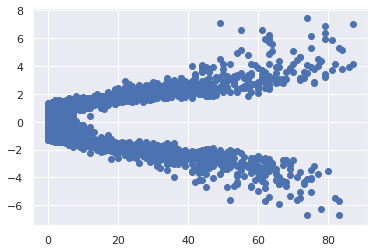

In [156]:
plt.scatter(deg_cohorts.sum(axis=1), tab_gt["logFC"])

In [157]:
mcc, prec, rec = get_array_metrics_numba(tab_gt["sig"].values, deg_cohorts.values)

In [164]:
tab_gt = tab_gt.sort_values(by="logFC")
deg_cohorts = deg_cohorts.loc[tab_gt.index]
bins = np.linspace(tab_gt["logFC"].min()-0.1, tab_gt["logFC"].max()+0.1, 20)
tab_gt['logFC_bin'] = pd.cut(tab_gt['logFC'], bins)

prec_dict = {}
for bin_val, bin_group in tab_gt.groupby('logFC_bin'):
    mcc, prec, rec = get_array_metrics_numba(bin_group["sig"].values, deg_cohorts.loc[bin_group.index].values)
    prec_dict[bin_val] = prec

/scratch/local/6261967/ipykernel_61717/4246425043.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for bin_val, bin_group in tab_gt.groupby('logFC_bin'):


(-6.83, -6.072]
Median prec: 1.0
Genes: 3 | NaN: 9


(-6.072, -5.314]
Median prec: 1.0
Genes: 9 | NaN: 7


(-5.314, -4.556]
Median prec: 1.0
Genes: 10 | NaN: 11


(-4.556, -3.797]
Median prec: 1.0
Genes: 30 | NaN: 3


(-3.797, -3.039]
Median prec: 1.0
Genes: 74 | NaN: 3


(-3.039, -2.281]
Median prec: 1.0
Genes: 146 | NaN: 4


(-2.281, -1.523]
Median prec: 0.9803921568627451
Genes: 386 | NaN: 3


(-1.523, -0.765]
Median prec: 0.31089536138079826
Genes: 1316 | NaN: 4


(-0.765, -0.00638]
Median prec: 0.0
Genes: 7259 | NaN: 12


(-0.00638, 0.752]
Median prec: 0.0
Genes: 7783 | NaN: 20


(0.752, 1.51]
Median prec: 0.3157894736842105
Genes: 1331 | NaN: 6


(1.51, 2.268]
Median prec: 0.98
Genes: 348 | NaN: 3


(2.268, 3.026]
Median prec: 1.0
Genes: 152 | NaN: 2


(3.026, 3.785]
Median prec: 1.0
Genes: 51 | NaN: 3


(3.785, 4.543]
Median prec: 1.0
Genes: 28 | NaN: 4


(4.543, 5.301]
Median prec: 1.0
Genes: 11 | NaN: 6


(5.301, 6.059]
Median prec: 1.0
Genes: 7 | NaN: 11


(6.059, 6.817]
Medi

/scratch/local/6261967/ipykernel_61717/2323415415.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for bin_val, bin_group in tab_gt.groupby('logFC_bin'):


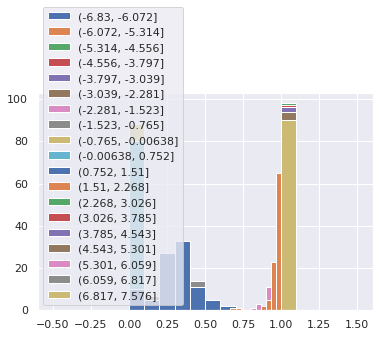

In [165]:
mid = []
precs = []
for bin_val, bin_group in tab_gt.groupby('logFC_bin'):
    mcc, prec, rec = get_array_metrics_numba(bin_group["sig"].values, deg_cohorts.loc[bin_group.index].values)
    mid.append(bin_val.mid)
    precs.append(np.nanmedian(prec))
    
    print(bin_val)
    print("Median prec:", np.nanmedian(prec))
    print("Genes:",len(bin_group),"| NaN:", np.isnan(prec).sum())
    plt.hist(prec, label=bin_val)
    print("\n")
    
plt.legend()

Text(0, 0.5, 'Median precision')

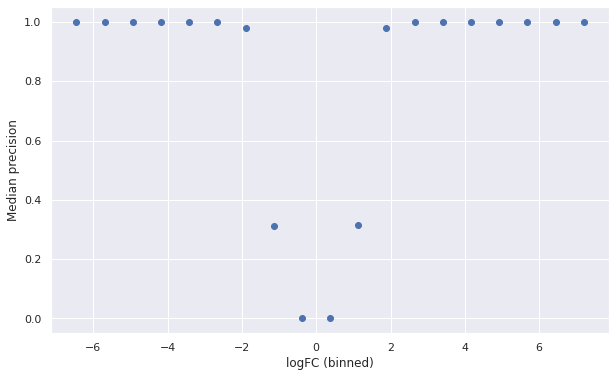

In [166]:
plt.figure(figsize=(10,6))
plt.scatter(mid,precs)
plt.xlabel("logFC (binned)")
plt.ylabel("Median precision")

## Inflation

In [80]:
from misc import open_table, get_grid_size
from process import gene_rep

datapath = "/storage/homefs/pd21v747/datanew"

def gene_reps_all_N(all_N,site,data,out,dea,FDR,logFC,param_set):
    gene_reps = {N: None for N in all_N}
    for N in all_N:
        tab = open_table(f"{datapath}/{site}/{data}/{data}_N{N}/all.FDR.{out}.{dea}.{param_set}")
        tablfc = open_table(f"{datapath}/{site}/{data}/{data}_N{N}/all.logFC.{out}.{dea}.{param_set}")
        gene_reps[N] = gene_rep(tab, logFC_tab=tablfc, FDR=FDR, logFC=logFC, normalize=True)
    return gene_reps


def get_truth_logFC(param_set, n_cohorts):
    
    logFC_test = 0 if param_set == "p1" else 1
    
    truth_logFC = {data: {dea: {N: {"RMSE":[], "logFC":[], "Error": []} for N in all_N_sub} | {"small_N_deg_logFC":[],"small_N_deg_logFC_truth":[]} for dea in DEAs} for data in datasets if "syn_hom" not in data}

    for data in truth_logFC:
        
        print(data)
        
        for dea in ["deseq2", "edgerlrt"]:
            
            path = datasets[data]['datapath'].split(f'/{data}.csv')[0]
            f = f"{path}/{data}.{dea}.lfc{logFC_test}.csv"
            truth_df=pd.read_csv(f, index_col=0, usecols=["Unnamed: 0","logFC"])
            logFC_truth = truth_df["logFC"]
            truth_logFC[data][dea]["truth"] = logFC_truth
            small_N_deg = []
            
            for N in all_N_sub:
                
                path_N = f"{path}/{data}_N{N}"
                cohorts = sorted([f.path for f in os.scandir(path_N) if f.is_dir()])

                for cohort in cohorts[:n_cohorts]:
                    
                    f = f"{cohort}/tab.{out}.{dea}.{param_set}"
                    tab_cohort = open_table(f)

                    logFC_cohort = tab_cohort["logFC"]
                    
                    if cohort == cohorts[0]: 
                        common = logFC_cohort.index.intersection(logFC_truth.index)
                    tab_cohort = tab_cohort.loc[common]

                    if N == all_N_sub[0]:
                        DEG = tab_cohort[(tab_cohort["FDR"]<FDR) & (tab_cohort["logFC"].abs()>logFC)]
                        truth_logFC[data][dea]["small_N_deg_logFC"] += DEG["logFC"].values.tolist() # faster than np.concatenate
                        small_N_deg = DEG.index

                    logFC_cohort = tab_cohort["logFC"]
                    rmse = np.sqrt(np.mean((logFC_truth.loc[common].values.flatten()-logFC_cohort.values)**2))
                    truth_logFC[data][dea][N]["RMSE"].append(rmse)
                    truth_logFC[data][dea][N]["Error"] += (logFC_truth.loc[common].values.flatten()-logFC_cohort.values).tolist()
                    truth_logFC[data][dea][N]["logFC"] += logFC_cohort.tolist()

            truth_logFC[data][dea]["small_N_deg_logFC_truth"] += logFC_truth.loc[small_N_deg].values.tolist()
            
    return truth_logFC

# don't forget: deseq2 does not show logCPM but counts

In [83]:
all_N_sub = [3,9,15]
FDR = 0.01
logFC = 1
out = "none" # outlier method
n_cohorts = 10
overwrite = False
paramset = "p1"

truth_logFC = get_truth_logFC(paramset, n_cohorts)

THCA
LUAD
KIRC
COAD
BRCA
LIHC
PRAD


In [98]:
print(truth_logFC["THCA"]["edgerlrt"].keys())

len(truth_logFC["THCA"]["edgerlrt"]["small_N_deg_logFC"])
len(truth_logFC["THCA"]["edgerlrt"]["small_N_deg_logFC_truth"])

dict_keys([3, 9, 15, 'small_N_deg_logFC', 'small_N_deg_logFC_truth', 'truth'])


1698

# Unpaired designs

In [4]:
combined_td2 = pd.read_csv("../data/multi/combined_td.p2.csv", index_col=0) # Paired formal lfc 1
combined_td3 = pd.read_csv("../data/multi/combined_td.p3.csv", index_col=0) # Unpaired formal lfc 1

combined_td3["DEA"] = combined_td3["DEA"].str.replace("edgerqlf","edgeR QLF")

In [5]:
combined_td2 = combined_td2[(combined_td2["DEA"]=="edgeR QLF")&(combined_td2["N"].isin([3,7,15]))&(combined_td2["FDR"]==0.05)]

len(combined_td2),len(combined_td3)

(21, 21)

/storage/homefs/pd21v747/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/storage/homefs/pd21v747/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/storage/homefs/pd21v747/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/storage/homefs/pd21v747/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use 

<Axes: xlabel='N', ylabel='median_rec'>

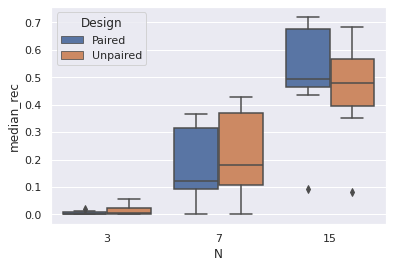

In [8]:
combined_td2["Design"] = "Paired"
combined_td3["Design"] = "Unpaired"

df = pd.concat([combined_td2, combined_td3])

sns.boxplot(data=df, x="N", y="median_rec",hue="Design")

## Test cases

In [72]:
site = "colorectal"
data = "COAD"
N = 3
cohort = 2

# Results from sent batch jobs
f3 = f"/storage/homefs/pd21v747/RNASeqReplicability/data/{site}/{data}/{data}_N{N}/{data}_N{N}_{cohort:04}/tab.none.edgerqlf.p3.feather" # unpaired
f2 = f"/storage/homefs/pd21v747/RNASeqReplicability/data/{site}/{data}/{data}_N{N}/{data}_N{N}_{cohort:04}/tab.none.edger.p2.feather" # paired
tab_unpaired = open_table(f3)
tab_paired = open_table(f2)

# Unpaired and paired results should yield different results
print((tab_paired["logFC"]==tab_unpaired.loc[tab_paired.index]["logFC"]).sum(), len(tab_paired))
(tab_paired["FDR"]==tab_unpaired.loc[tab_paired.index]["FDR"]).sum(), len(tab_paired)

0 17336


(0, 17336)

In [73]:
# Re-run DEA here

from DEA import run_dea

config = f"/storage/homefs/pd21v747/RNASeqReplicability/data/{site}/{data}/{data}_N{N}/{data}_N{N}_{cohort:04}/config.json"

with open(config, "r") as f:
    j = json.load(f)    
    samples_i = j["samples_i"]
    
df_cohort = pd.read_csv(f"/storage/homefs/pd21v747/RNASeqReplicability/data/{site}/{data}/{data}.csv", index_col=0)
df_cohort = df_cohort[samples_i]

outfile = "../data/test/unpaired.csv"
kwargs = {"filter_expr": False, "cols_to_keep": ["logFC","logCPM","FDR"], "lfc": 1, "design": "unpaired"}
run_dea(df_cohort, outfile, method="edgerqlf", overwrite=True, **kwargs)

outfile_paired = "../data/test/paired.csv"
kwargs = {"filter_expr": False, "cols_to_keep": ["logFC","logCPM","FDR"], "lfc": 1, "design": "paired"}
run_dea(df_cohort, outfile_paired, method="edgerqlf", overwrite=True, **kwargs)

In [74]:
df_unpaired = pd.read_csv(outfile, index_col=0)
df_paired = pd.read_csv(outfile_paired, index_col=0)
(df_paired["FDR"] == df_unpaired.loc[df_paired.index]["FDR"]).sum(), len(df_paired)

(0, 17336)

In [77]:
assert np.allclose(df_paired["FDR"], tab_paired.loc[df_paired.index]["FDR"])
assert np.allclose(df_unpaired["FDR"], tab_unpaired.loc[df_unpaired.index]["FDR"])

In [78]:
fdr = 0.05
print(len(df_paired[df_paired["FDR"]<fdr]))
print(len(tab_paired[tab_paired["FDR"]<fdr]))
print(len(df_unpaired[df_unpaired["FDR"]<fdr]))
print(len(tab_unpaired[tab_unpaired["FDR"]<fdr]))

216
216
467
467
